# **Introduction to Computer Vision - Fall 2021**

# Midterm Exam ( Practical Test )

# 13.09.2021

## submit before 12:40

**Submit a copy of this file including your solution with results in a ipynb file (your_name.ipynb)**



In [40]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2

In [41]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
clear_output()

In [42]:
# function to read and resize an image
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

    
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

### **Task 1 (40%)** 

Detect the object shown in Fig. 1 within the scene in Fig. 2. using SIFT

Display the good matching key points

Crop the detected object out of the source image

Results for each step should be printed, comments on the codes are required



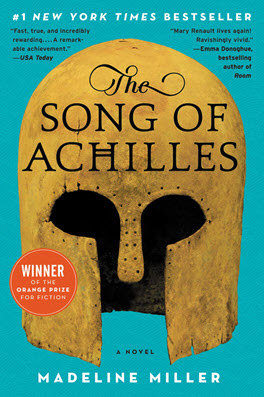

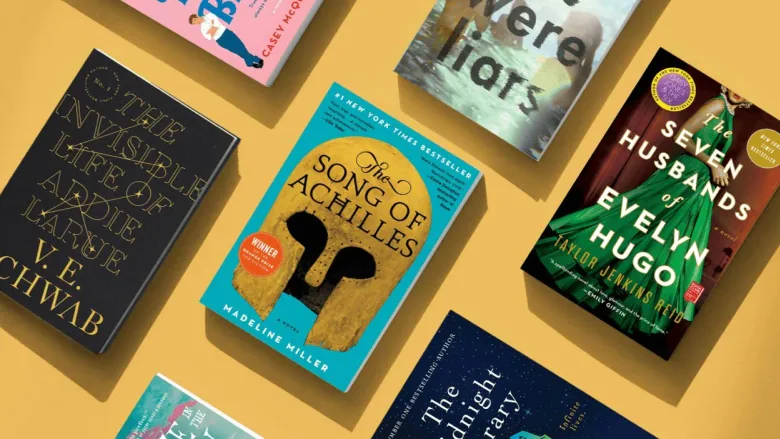

In [43]:
# Download the image
!wget https://www.dropbox.com/s/b3o5yomqvzteipe/Copy%20of%20Copy%20of%2081msb6gUBTL.jpg?dl=0 -O book.jpg
!wget https://www.dropbox.com/s/2uqbajma9nnb490/indigo-booktok.webp?dl=0 -O scene.jpg
clear_output()

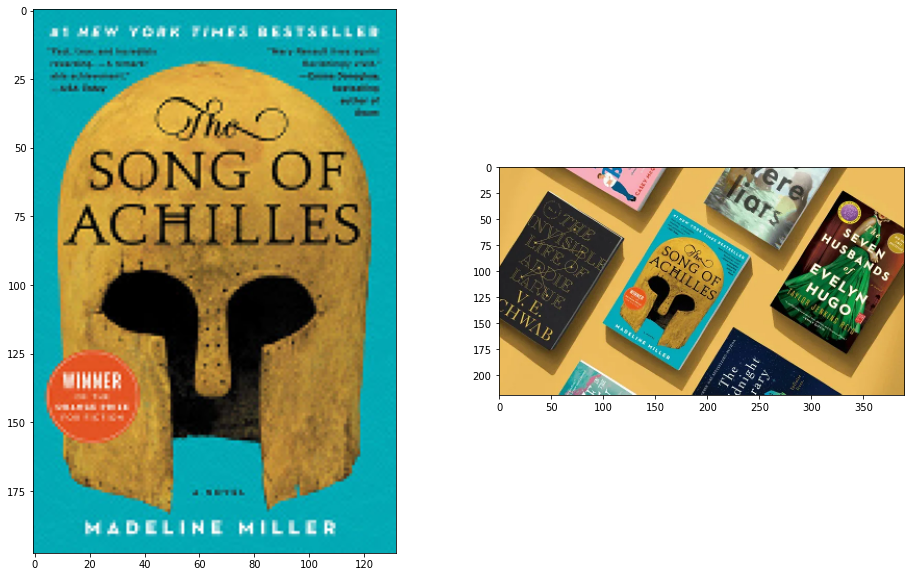

In [44]:
# Load and display images (5%)

book = read_and_resize('book.jpg', 0)
scene = read_and_resize('scene.jpg', 0)

showInRow([book, scene])

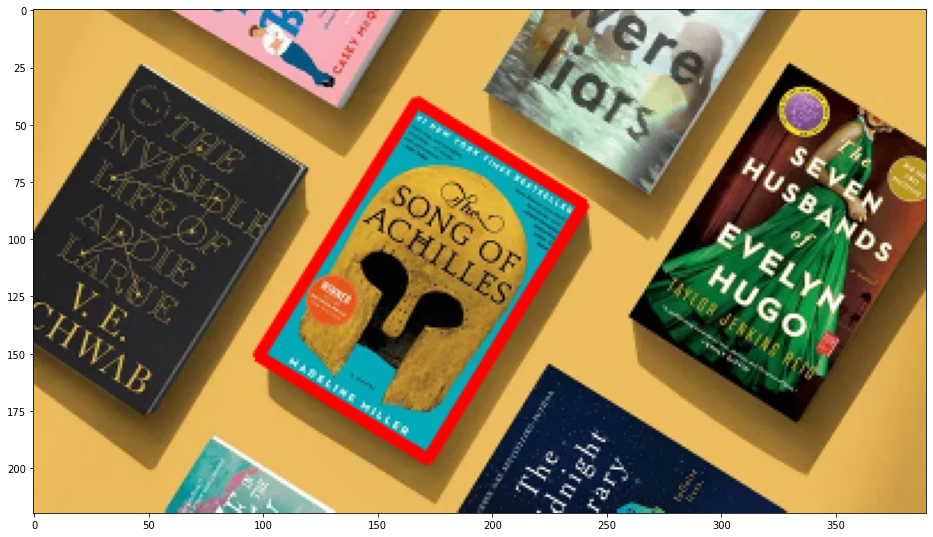

In [45]:
# write your code for object detection (10%)

MIN_MATCH_COUNT = 10

sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(book,None)
kp2, des2 = sift.detectAndCompute(scene,None)


# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

sceneRemoved = scene.copy()

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    # findHomography returns a mask that tells us, which point pairs did not pass the RANSAC filter
    matchesMask = mask.ravel().tolist()

    h,w,c = book.shape
    # Take corners of the first image and transform them onto the second image
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    # cropping out detected object
    sceneRemoved = cv2.fillPoly(sceneRemoved, np.int32([dst]), (0, 0, 0))

    scene = cv2.polylines(scene,[np.int32(dst)],True,(255, 0, 0),3, cv2.LINE_AA)

else:
    print ("Not enough matches were found, only %d. Needed: %d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

showInRow([scene])

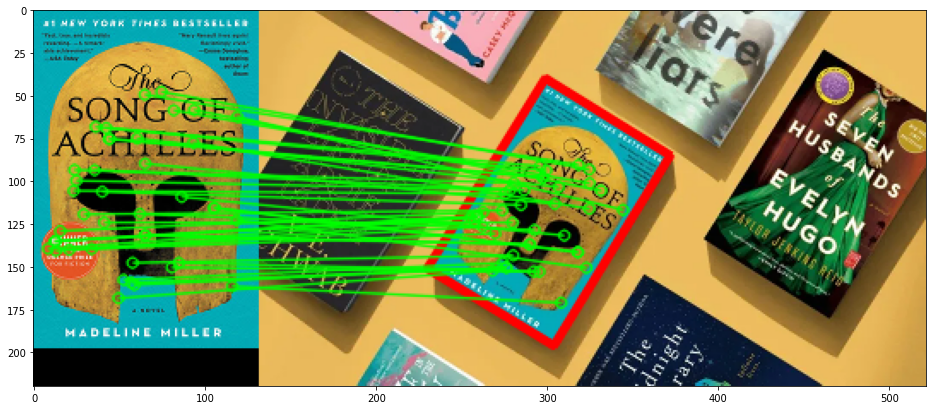

In [46]:
# display good matching (10%)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(book,kp1,scene,kp2,good,None,**draw_params)

showInRow([img3])

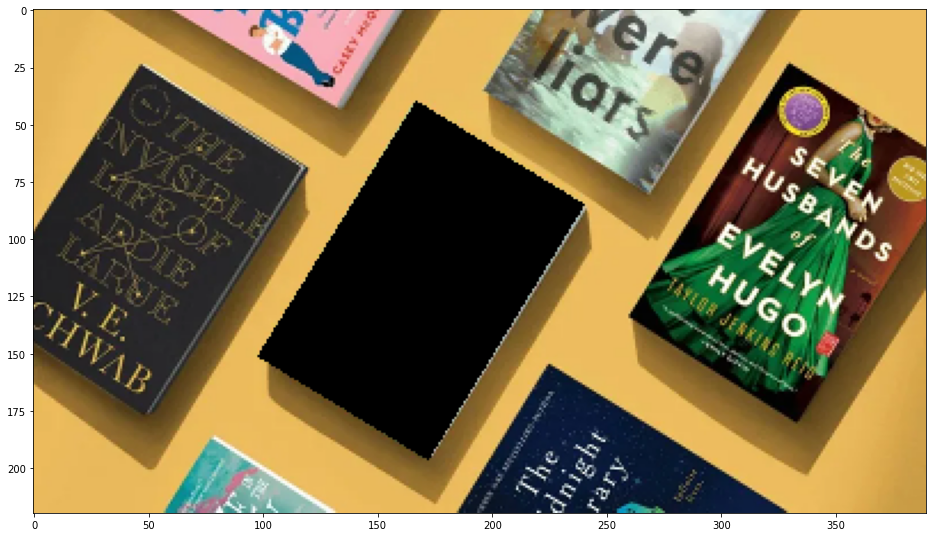

In [47]:
# crop out (remove) the detected object from the scene (15%)

showInRow([sceneRemoved])

### **Task 2 (60%)**

The aim of this task is to extract the plate of the key shown in Fig.3 that has the number, the final result should be similar to Fig. 4.

DO NOT use template matching or any detection method.

**Results for each step should be printed, comments on the codes are required**


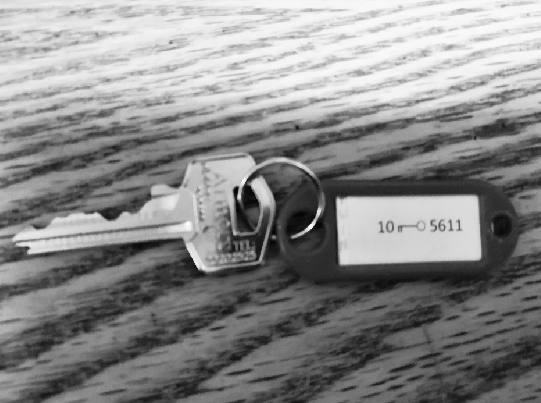


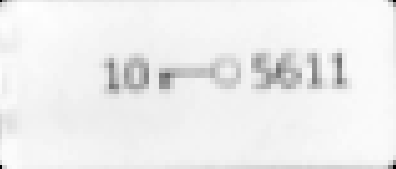







In [140]:
# Download the image
!wget https://www.dropbox.com/s/evoml3c3xlh7633/key.jpg?dl=0 -O keys.jpg
clear_output()

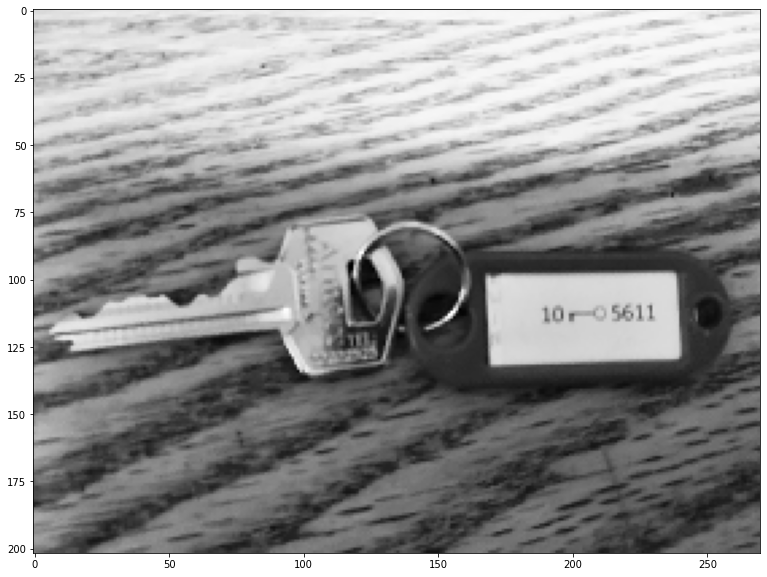

In [161]:
# Load and display the image (5%)

keys = read_and_resize('keys.jpg', 0)

showInRow([keys])

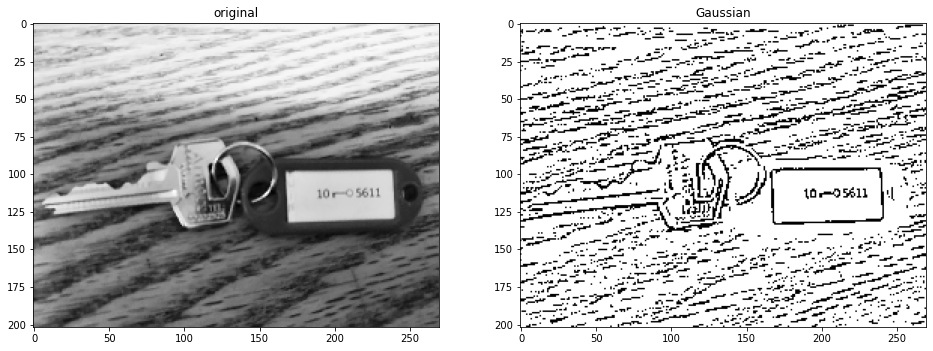

In [191]:
# Apply adaptive thresholding, using slider, and adjust the threshold value to get the best output (15%)

#@title Parameters { run: "auto" }
block_size = 5 #@param {type:"slider", min:1, max:55, step:2}
c_value = 9 #@param {type:"slider", min:-40, max:40, step:1}

keys_gray = cv2.cvtColor(keys, cv2.COLOR_BGR2GRAY)

binary_keys = cv2.adaptiveThreshold(keys_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c_value)


showInRow([keys, binary_keys], titles=["original", "Gaussian"])

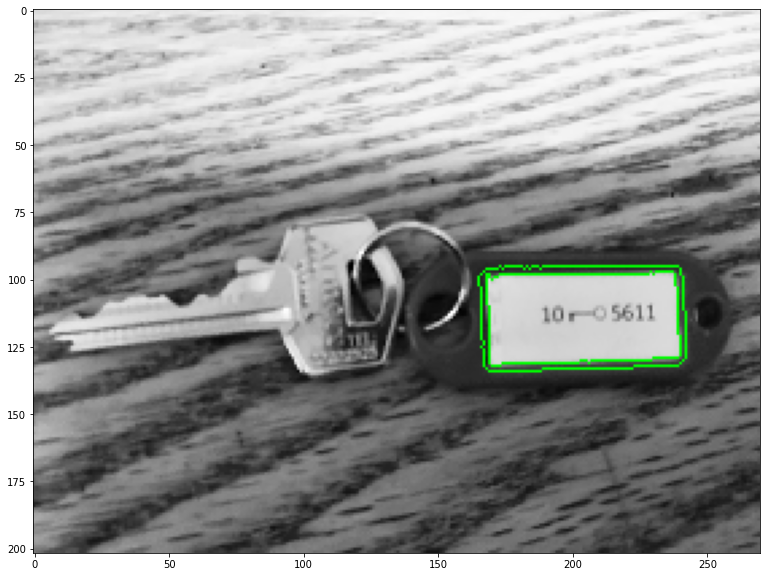

In [199]:
# For the binary image resulted from the thresholding, obtain the contours of the objects. 
# Then, among all contours, consider only the one of the plate. (20%)
# HHint: use CHAIN_APPROX_SIMPLE to extract minimum points that represent the contour.

_, contours, hierarchy = cv2.findContours(binary_keys, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

im = keys.copy()

# find contour with maximum area
biggest_area = -1
ind = -1
for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > biggest_area:
          biggest_area = cv2.contourArea(contours[i])
          ind = i

# delete contour which goes along the sides of image
contours.pop(ind)

# find contour with maximum area
biggest_area = -1
ind = -1
for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > biggest_area:
          biggest_area = cv2.contourArea(contours[i])
          ind = i
img = cv2.drawContours(im, contours[ind], -1, (0, 255, 0), 1)
showInRow([img])

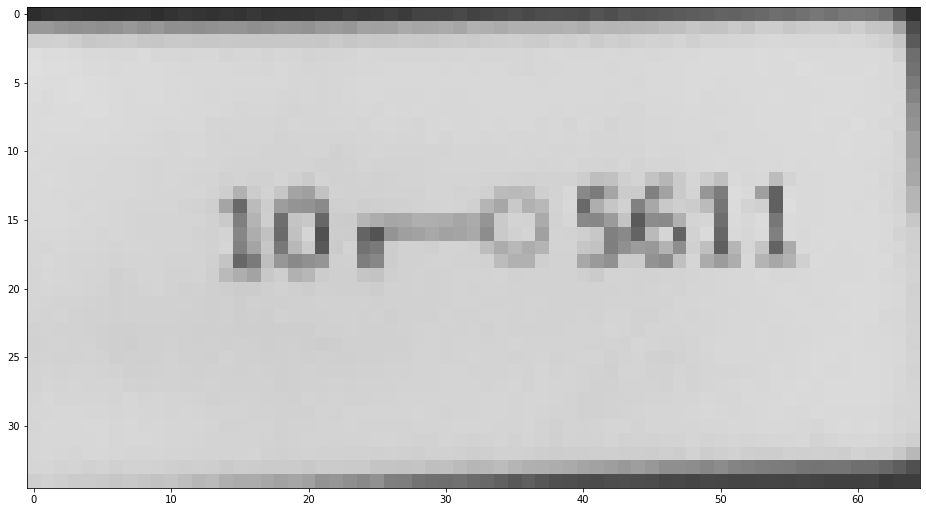

In [159]:
# crop the region of the image that includes the numbers.
# and Do all necessary transformations to get closest imsge to the one in Fig. 4 (20%)

numbers = keys[97:132, 175:240]
showInRow([numbers])